In [1]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

import sys 
sys.path.append(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

# data wrangling libs
import numpy as np 
import pandas as pd 
from siuba import * 
from siuba.dply.vector import *

# random methods
from LopezRandomMethod import random_gen_weights
from randomness_by_RogerStafford import randfixedsum 

# UDF: unit circle df (sine and cosine coordinates), dowloading historical stock prices
from unitCircle import unitCircle as unitCircleDf
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns

# graphing
import matplotlib.pyplot as plt 
from plotnine import * 

# optimization
from scipy.optimize import minimize # SLSQP
from simanneal import Annealer # Annealing
from scipy.optimize import dual_annealing

import time  # to time processes 

np.random.seed(1986)


The current working directory is: D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz


In [2]:
import yfinance as yf

# Define the ticker symbol for Dow Jones Industrial Average
ticker = '^DJI'

# Download historical data
djia_data = yf.download(ticker, start='2020-01-01', end='2024-08-01')
dji_pricehist=missing_days_andIndexTimeZone(djia_data['Close'])

[*********************100%***********************]  1 of 1 completed


In [3]:
cambios_dji_hist=dji_pricehist.pct_change().dropna()

In [4]:
from siuba import * 
from siuba.dply.vector import * 
from plotnine import *

In [5]:
from scipy.stats import shapiro , ranksums

In [6]:
shapiro(cambios_dji_hist)[1]

8.413932290920873e-35

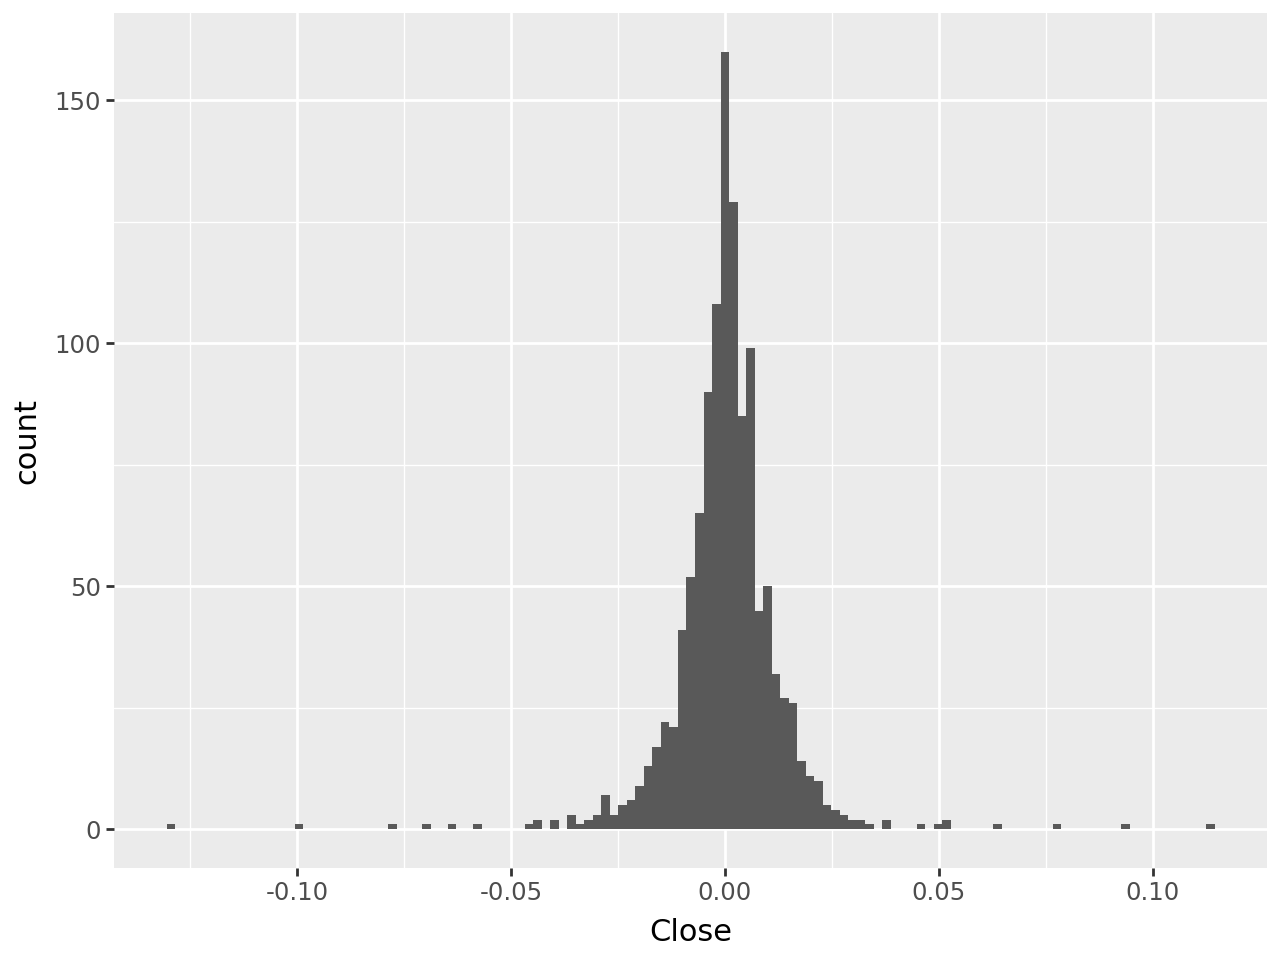

In [7]:
cambios_dji_hist.reset_index() >> ggplot() + geom_histogram(aes(x='Close'))

## Probar Normalidad SLSQP 

- Necesito precios historicos 
- Necesito cambio de precios 
- Necesito el mejor portafolio ejemplo de cualquier periodo

Formula final una vez que tengamos lo siguiente:
- Cambios de precios 
- Pesos optimos 

## Precios Historicos

In [8]:
from datetime import date 
def fn_get_histPrice(fn_startFecha:date, fn_endFecha:date)->pd.DataFrame:
    #downloading 1 year of data
    df_ticker = download_data(list_stocks=tickerList,start_date = fn_startFecha.strftime('%Y-%m-%d'), end_date = fn_endFecha.strftime('%Y-%m-%d'))
    df_tickerprice1=missing_days_andIndexTimeZone(df_ticker)
    return df_tickerprice1

In [9]:
hist_price_companies = fn_get_histPrice(date(2020,1,1),date(2024,8,1))

[*********************100%***********************]  30 of 30 completed


In [42]:
last12_returns = hist_price_companies >> filter(_.index >= '2023-08-01', _.index<'2024-08-01') >> _.pct_change().dropna()

## SLSQP Last 12 Months 

In [11]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41 # times 41 b/c there are 41 trading days in August and Sept

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

In [12]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(last12_returns.shape[1])]

In [31]:
result_SLSQP_last12months = minimize(sharpe_ratio, 
                                     np.full(30, 1/30), 
                                     args=(last12_returns,), # change depending on time period
                                     method='SLSQP', 
                                     bounds=bounds, 
                                     constraints=constraints)

### Comparando Distribuciones de Retornos DJI vs SLSQP

In [92]:
ret_dji_last12months=cambios_dji_hist.reset_index() >> filter(_.Date>='2023-08-02')>> mutate(index = 'DJI') >> rename(Pct_Change = 'Close')
ret_dji_last12months

,Date,Pct_Change,index
933,2023-08-02,-0.009771,DJI
934,2023-08-03,-0.001888,DJI
935,2023-08-04,-0.004267,DJI
936,2023-08-07,0.011621,DJI
937,2023-08-08,-0.004472,DJI
...,...,...,...
1189,2024-07-25,0.002037,DJI
1190,2024-07-26,0.016383,DJI
1191,2024-07-29,-0.001217,DJI
1192,2024-07-30,0.005017,DJI


(261, 30)

In [93]:
ret_SLSQP_last12months=last12_returns.dot(result_SLSQP_last12months.x).reset_index().rename(columns = {0:'Pct_Change'}) >> mutate(index='SLSQP')
ret_SLSQP_last12months.tail(2)

,Date,Pct_Change,index
259,2024-07-30,0.004707,SLSQP
260,2024-07-31,0.000253,SLSQP


In [145]:
expected_returns=pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> group_by(_.index) >> summarize(ave_return = _.Pct_Change.mean()) >> _.ave_return

exp_ret_DJI,exp_ret_SLSQP =expected_returns[0],expected_returns[1]
exp_ret_DJI  ,exp_ret_SLSQP 

(0.0005424259607218472, 0.0012904829646139216)

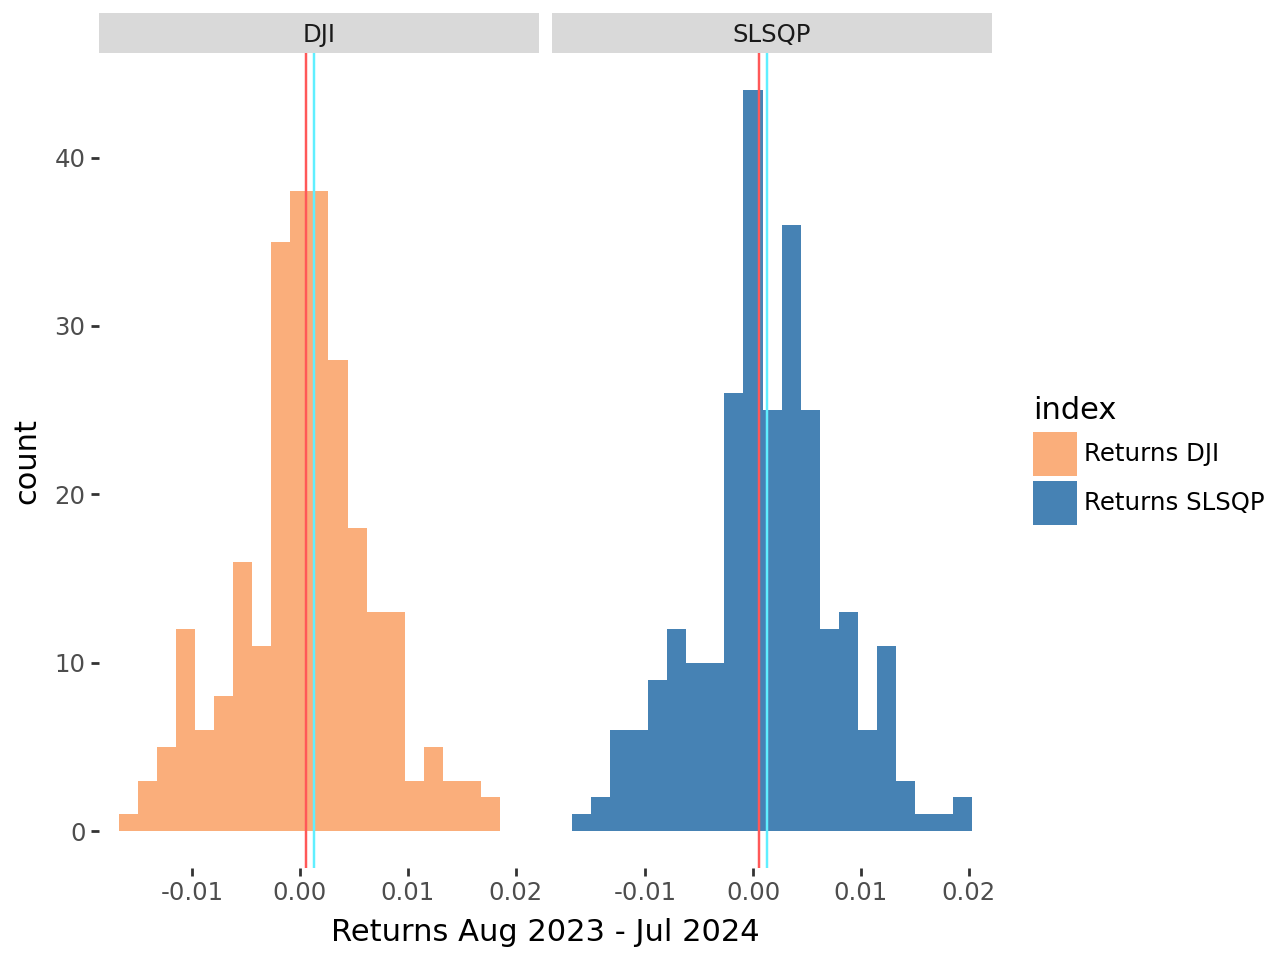

In [143]:
ch5_graph_dist_returns_dji_slsqp=pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> arrange(_.Pct_Change) >> ggplot() + \
    geom_histogram(aes(x='Pct_Change', fill = 'index'), position='identity')+facet_wrap('~index')+\
scale_fill_manual(
        values={
            'DJI': '#faae7b',
            'SLSQP': 'steelblue'
        },
        labels={
            'DJI': 'Returns DJI',
            'SLSQP': 'Returns SLSQP'
        }        
    ) +\
geom_vline(xintercept = exp_ret_DJI, color= '#ff5858') + geom_vline(xintercept = exp_ret_SLSQP, color= '#60efff') +\
theme(panel_background= element_rect(fill='white')) + labs(x='Returns Aug 2023 - Jul 2024')
ch5_graph_dist_returns_dji_slsqp


In [141]:
ch5_graph_dist_returns_dji_slsqp.save(filename='ch5_graph_dist_returns_dji_slsqp',dpi=1000)

### Mean-Reverting DJI vs SLSQP

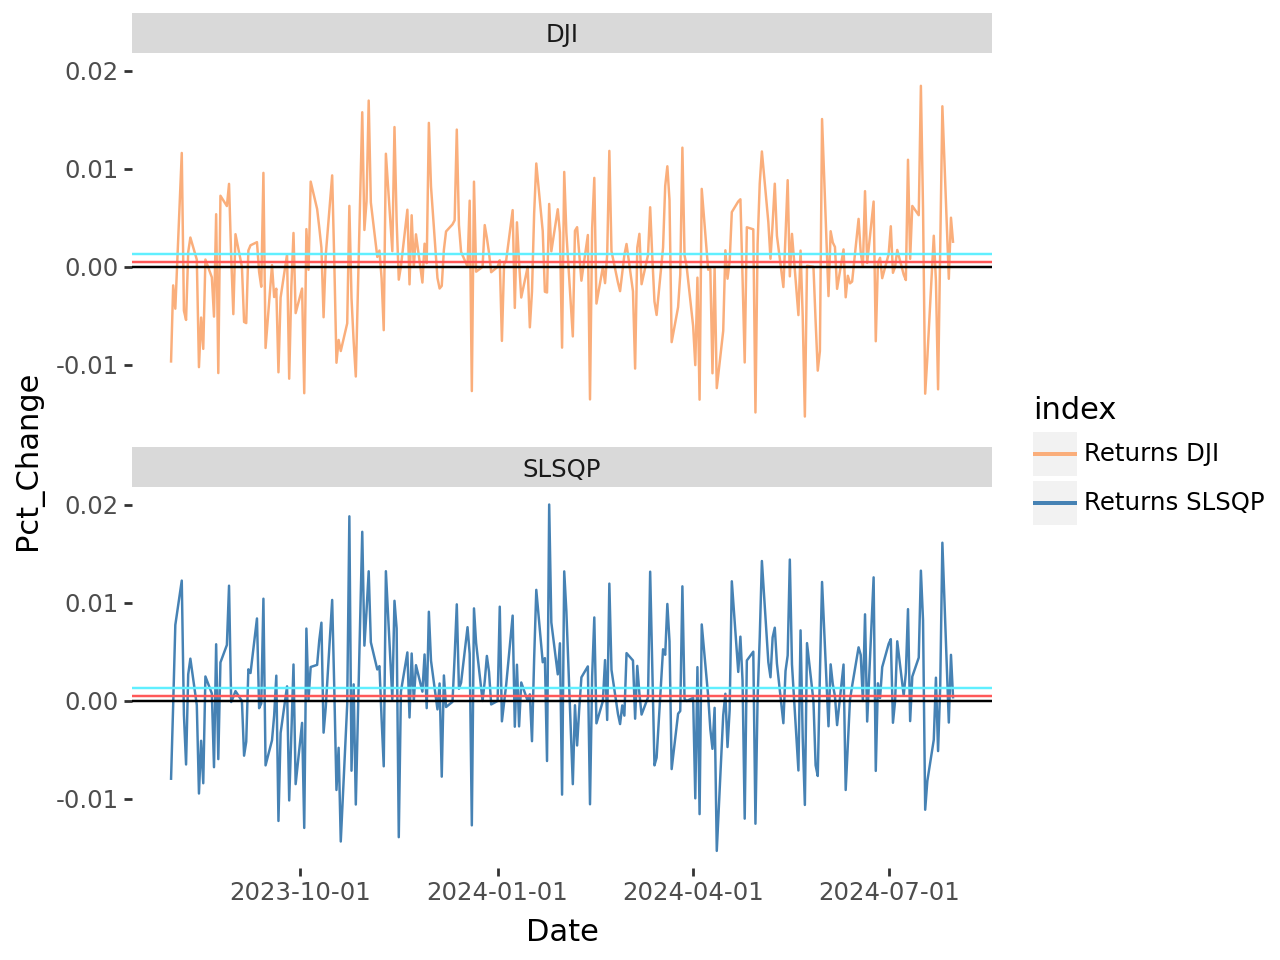

In [160]:
ch5_graph_meanReverting=pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> ggplot() + geom_line(aes(x='Date',y='Pct_Change',color = 'index')) +\
facet_wrap('~index',nrow=2) +\
      scale_color_manual(
        values={
            'DJI': '#faae7b',
            'SLSQP': 'steelblue'
        },
        labels={
            'DJI': 'Returns DJI',
            'SLSQP': 'Returns SLSQP'
        }        
    ) +\
    theme(panel_background= element_rect(fill='white')) +\
    geom_hline(yintercept = exp_ret_DJI, color= '#ff5858') + geom_hline(yintercept = exp_ret_SLSQP, color= '#60efff') +\
    geom_hline(yintercept = 0, color= 'black')
ch5_graph_meanReverting

In [161]:
ch5_graph_meanReverting.save(filename='ch5_graph_meanReverting',dpi=1000)

### Test of Stationarity (Dickey-Fuller Test)

In [162]:
from statsmodels.tsa.stattools import adfuller

In [193]:
pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> rename(index_select = 'index') >>\
group_by(_.index_select) >>summarize(dickey_fuller_test= _['Pct_Change'].agg(adfuller)[1])

,index_select,dickey_fuller_test
0,DJI,3.772399e-27
1,SLSQP,3.445826e-29


### Compounded Rate of Return

In [ ]:
def 

In [210]:
ret_dji_last12months

,Date,Pct_Change,index
933,2023-08-02,-0.009771,DJI
934,2023-08-03,-0.001888,DJI
935,2023-08-04,-0.004267,DJI
936,2023-08-07,0.011621,DJI
937,2023-08-08,-0.004472,DJI
...,...,...,...
1189,2024-07-25,0.002037,DJI
1190,2024-07-26,0.016383,DJI
1191,2024-07-29,-0.001217,DJI
1192,2024-07-30,0.005017,DJI


In [238]:
def compounded_rate_return(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000) -> float:
    _1_plus_return=fn_seriesReturns + 1
    _1_plus_return_list=[x for x in _1_plus_return]
    _1_plus_return_list.insert(0,fn_init_investment)
    last_value = [x for x in pd.Series(_1_plus_return_list).cumprod()][-1]
    first_value = fn_init_investment
    return (last_value/first_value) ** (1/len(fn_seriesReturns)) -1   

def last_value_expected(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000) -> float:
    _1_plus_return=fn_seriesReturns + 1
    _1_plus_return_list=[x for x in _1_plus_return]
    _1_plus_return_list.insert(0,fn_init_investment)
    last_value = [x for x in pd.Series(_1_plus_return_list).cumprod()][-1]
    
    return last_value

def Series_dollar_expected_from_returns(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000) -> pd.Series:
    _1_plus_return=fn_seriesReturns + 1
    _1_plus_return_list=[x for x in _1_plus_return]
    _1_plus_return_list.insert(0,fn_init_investment)  
    
    return pd.Series(_1_plus_return_list).cumprod()

def Series_dollar_expected_fromCompoundedReturn(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000)-> pd.Series:
    _fndaily_returns=[x+1 for x in [compounded_rate_return(fn_seriesReturns)] * len(fn_seriesReturns)]
    _fndaily_returns.insert(0,fn_init_investment)
    return pd.Series(_fndaily_returns).cumprod()


In [248]:
Series_dollar_expected_from_returns(ret_SLSQP_last12months.Pct_Change)[:70]

0     1.000000e+06
1     9.919431e+05
2     9.915424e+05
3     9.992324e+05
4     1.011504e+06
          ...     
65    9.966622e+05
66    1.005853e+06
67    1.019162e+06
68    1.025269e+06
69    1.028563e+06
Length: 70, dtype: float64

### SLSLQP with Risk and No Risk

In [272]:
index_lastYear_prices=hist_price_companies >> filter(_.index >= '2023-08-01', _.index<'2024-08-01') >> _.index

In [275]:
df_1mm_port_slsqp_risk_and_noRisk=pd.DataFrame({    
    'port_returns_SLSQP_wRisk': Series_dollar_expected_from_returns(ret_SLSQP_last12months.Pct_Change),
    'port_returns_SLSQP_noRisk': Series_dollar_expected_fromCompoundedReturn(ret_SLSQP_last12months.Pct_Change) 
}) #.melt() >> ggplot() + geom_line(aes())

In [276]:
df_1mm_port_slsqp_risk_and_noRisk.index = index_lastYear_prices

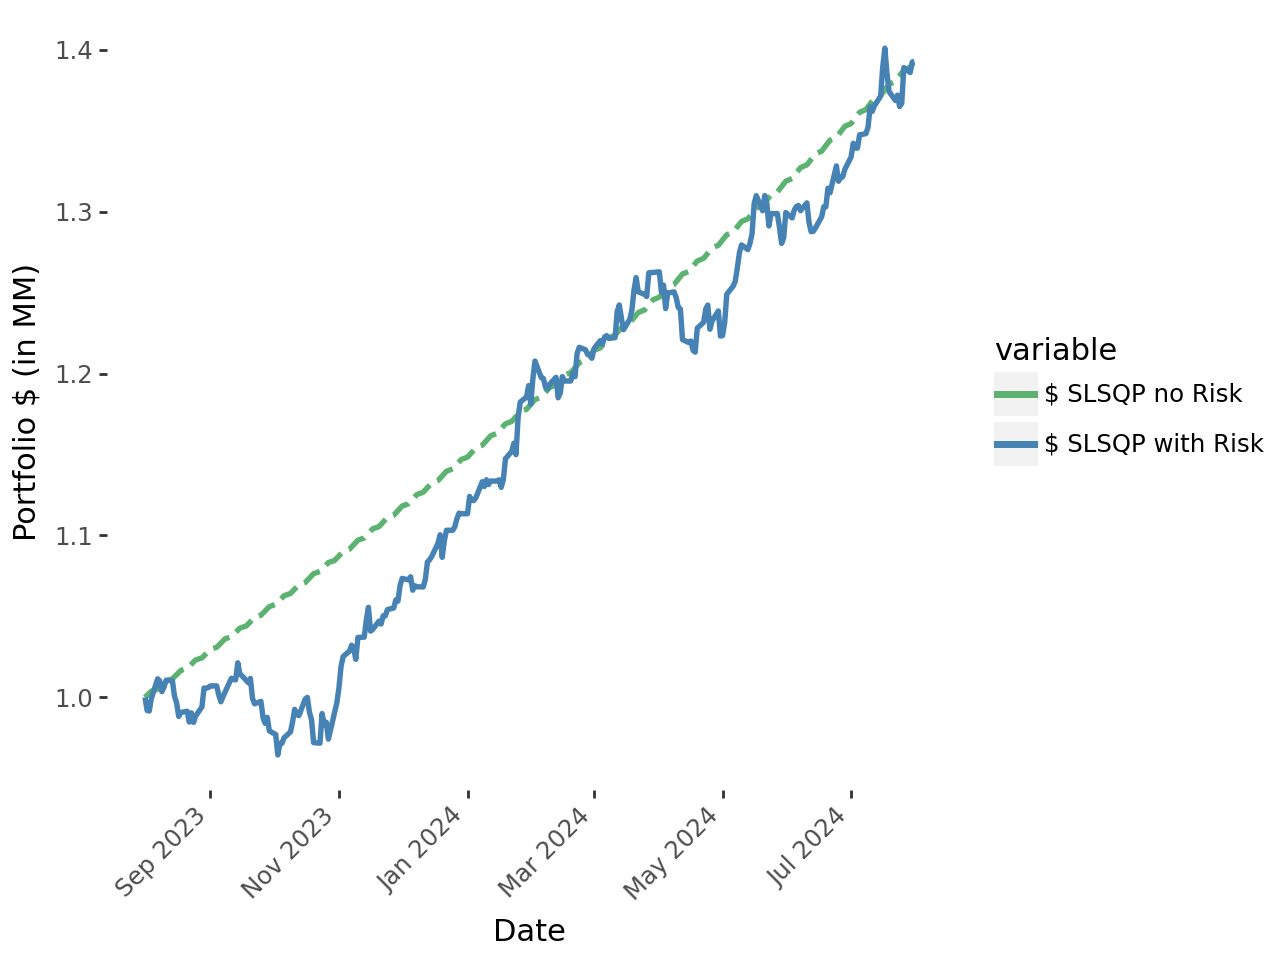

In [311]:
ch5_graph_port1MM_SLSQP_risk_vs_norisk=df_1mm_port_slsqp_risk_and_noRisk.reset_index().melt(id_vars='Date') >> mutate(value = _.value/1_000_000
                                                                               ) >>\
ggplot() + geom_line(aes(x='Date',y='value', color='variable', linetype='variable'), size=1.1) + labs(y='Portfolio $ (in MM)')+\
     scale_x_datetime(date_breaks="2 months", date_labels="%b %Y")+ theme(axis_text_x=element_text(angle=45, hjust=1))+\
      scale_color_manual(
        values={
            'port_returns_SLSQP_wRisk': 'steelblue',
            'port_returns_SLSQP_noRisk': '#5cb270'
        },
        labels={
            'port_returns_SLSQP_noRisk': '$ SLSQP no Risk',
            'port_returns_SLSQP_wRisk': '$ SLSQP with Risk'
        }        
    ) +\
      theme(panel_background=element_rect(fill='white'))+\
      scale_linetype_manual(values={'port_returns_SLSQP_wRisk': 'solid', 'port_returns_SLSQP_noRisk': 'dashed'})+ guides(linetype=False)

ch5_graph_port1MM_SLSQP_risk_vs_norisk

#+ scale_linetype_manual(values={'port_returns_SLSQP_wRisk': 'solid', '$ SLSQP with Risk': 'dashed'})+\

In [312]:
ch5_graph_port1MM_SLSQP_risk_vs_norisk.save(filename='ch5_graph_port1MM_SLSQP_risk_vs_norisk',dpi=1000)

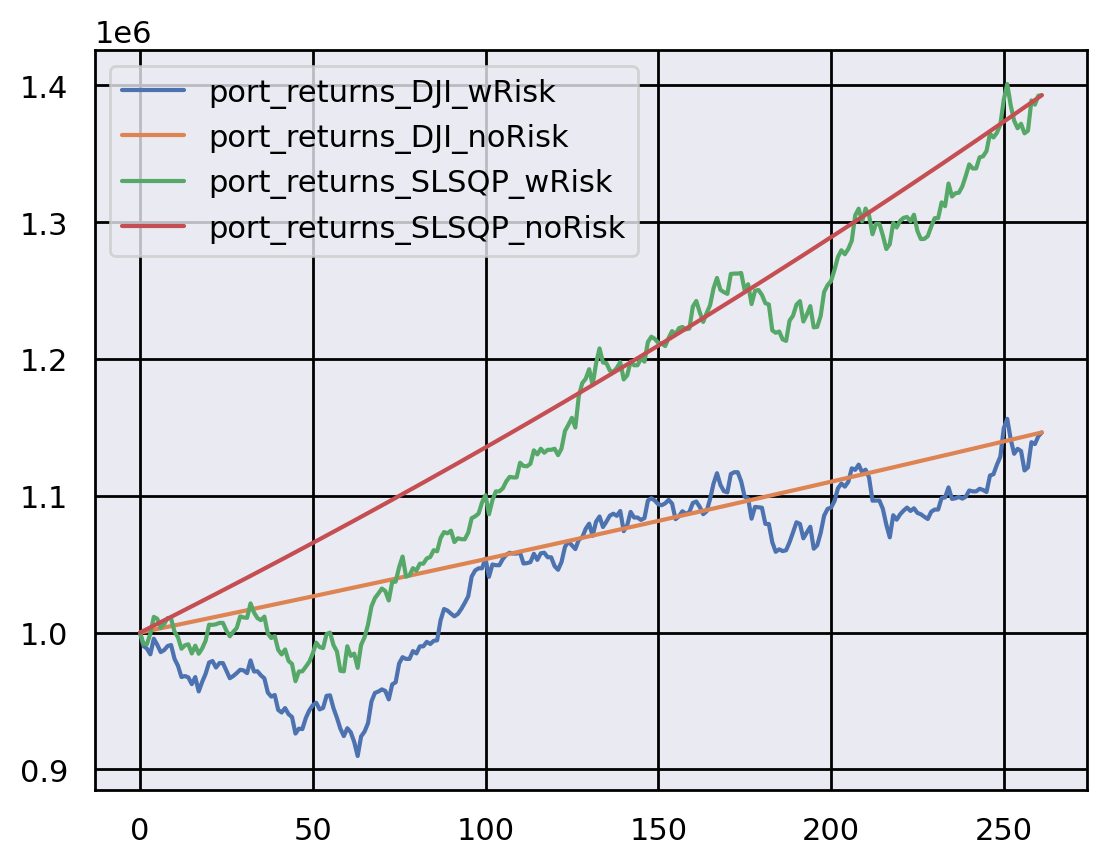

In [250]:
#Series_dollar_expected_fromCompoundedReturn(ret_SLSQP_last12months.Pct_Change)


pd.DataFrame({
    'port_returns_DJI_wRisk': Series_dollar_expected_from_returns(ret_dji_last12months.Pct_Change),
    'port_returns_DJI_noRisk': Series_dollar_expected_fromCompoundedReturn(ret_dji_last12months.Pct_Change),
    'port_returns_SLSQP_wRisk': Series_dollar_expected_from_returns(ret_SLSQP_last12months.Pct_Change),
    'port_returns_SLSQP_noRisk': Series_dollar_expected_fromCompoundedReturn(ret_SLSQP_last12months.Pct_Change) 
}).plot()
plt.show()

In [237]:
# print(compounded_rate_return(ret_dji_last12months.Pct_Change))
# print(ret_dji_last12months.Pct_Change.mean())

print(compounded_rate_return(ret_SLSQP_last12months.Pct_Change))
print(ret_SLSQP_last12months.Pct_Change.mean())
print(last_value_expected(ret_SLSQP_last12months.Pct_Change))
print(Series_dollar_expected_from_returns(ret_SLSQP_last12months.Pct_Change))




0.001270010931655241
0.0012904829646139216
1392725.3961939057
0      1.000000e+06
1      9.919431e+05
2      9.915424e+05
3      9.992324e+05
4      1.011504e+06
           ...     
257    1.366842e+06
258    1.388908e+06
259    1.385849e+06
260    1.392373e+06
261    1.392725e+06
Length: 262, dtype: float64


In [234]:
_daily_returns=[x+1 for x in [compounded_rate_return(ret_SLSQP_last12months.Pct_Change)] * len(ret_SLSQP_last12months.Pct_Change)]
_daily_returns.insert(0,1_000_000)
[x for x in pd.Series(_daily_returns).cumprod()][-1]

1392725.3961939323

In [217]:
_1_plus_return_dji=ret_dji_last12months.Pct_Change + 1
_1_plus_return_dji_list=[x for x in _1_plus_return_dji]
_1_plus_return_dji_list.insert(0,1_000_000)
last_value = [x for x in pd.Series(_1_plus_return_dji_list).cumprod()][-1]
first_value = 1_000_000
(last_value/first_value) ** (1/len(ret_dji_last12months.Pct_Change)) -1 

0.0005232143295836877

In [200]:
pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) 

,Date,Pct_Change,index
933,2023-08-02,-0.009771,DJI
934,2023-08-03,-0.001888,DJI
935,2023-08-04,-0.004267,DJI
936,2023-08-07,0.011621,DJI
937,2023-08-08,-0.004472,DJI
...,...,...,...
256,2024-07-25,0.001453,SLSQP
257,2024-07-26,0.016144,SLSQP
258,2024-07-29,-0.002202,SLSQP
259,2024-07-30,0.004707,SLSQP


In [47]:
result_SLSQP_last12months

np.dot(result_SLSQP_last12months.x, last12_returns.mean())*41

0.052909801549170785

In [ ]:
# formula final para aplicar :
## notar que estos no son los retornos de los ult 12 meses 
## se considerarian los retornos esperados en los ultimos 4 anhos dado que apliques los mejores pesos optimizados 

returns_bestPort_consolidated=(hist_price_companies >> _.pct_change().dropna()).dot(result_SLSQP_last12months.x)

### Midiendo Sharpe Ratio de DJI y de SLSLQP

In [33]:
cambios_dji_hist["2023-08-01":"2024-07-31"].mean()/cambios_dji_hist["2023-08-01":"2024-07-31"].std()

0.08837883296596495

In [39]:
cambios_dji_hist["2023-08-01":"2024-07-31"].mean()*41

0.022467687308947406

In [40]:
returns_bestPort_consolidated.mean()*41

0.02499411012763269

In [20]:
returns_bestPort_consolidated.mean()/returns_bestPort_consolidated.std()

0.051041396011580406

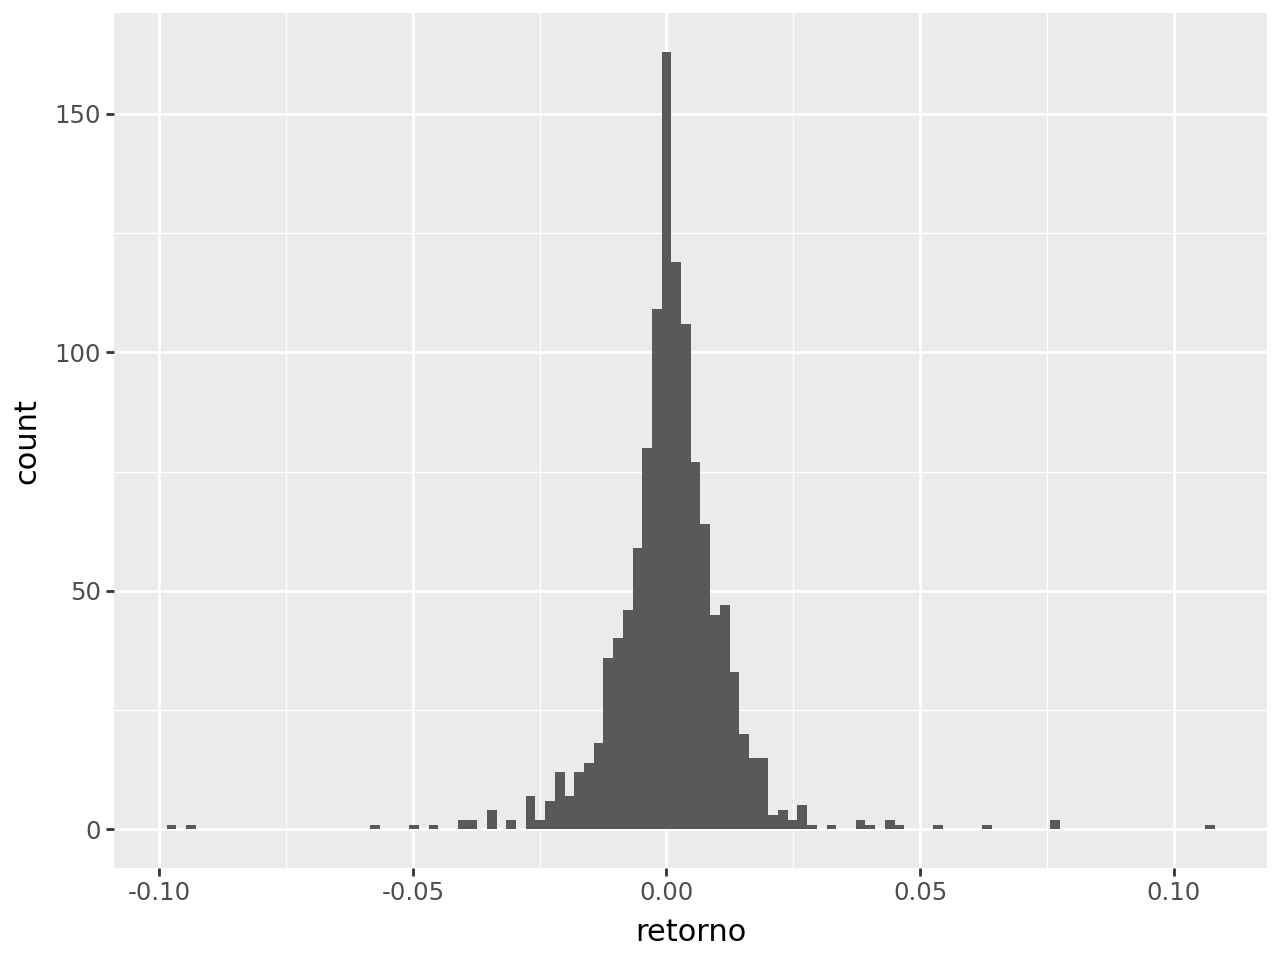

In [34]:
returns_bestPort_consolidated.reset_index().rename(columns={0:'retorno'}) >> ggplot() + geom_histogram(aes(x='retorno'))

In [40]:
returns_bestPort_consolidated.describe()

count    1194.000000
mean        0.000610
std         0.011943
min        -0.097633
25%        -0.004233
50%         0.000453
75%         0.005887
max         0.107134
dtype: float64

In [37]:
cambios_dji_hist.describe()*100

count    119400.000000
mean          0.037834
std           1.320648
min         -12.926546
25%          -0.463590
50%           0.038673
75%           0.587512
max          11.365041
Name: Close, dtype: float64

In [38]:
returns_bestPort_consolidated.std()

0.011943488216645112

In [39]:
cambios_dji_hist.std()

0.013206480407680134

In [46]:
(1.96*returns_bestPort_consolidated.std()/0.0002)**2

13699.809311420746

# Haciendo SLSQP basado en el periodo 2021-2022

In [92]:
_2021_return = hist_price_companies >> filter(_.index >= '2021-01-01',_.index < '2022-01-01' ) >> _.pct_change().dropna()
result_SLSQP_2021 = minimize(sharpe_ratio, np.full(30, 1/30), args=(_2021_return,), method='SLSQP', bounds=bounds, constraints=constraints)
returns_SLSQP_2022_onwards=(hist_price_companies>> filter(_.index >= '2022-01-01') >> _.pct_change().dropna()).dot(result_SLSQP_2021.x)

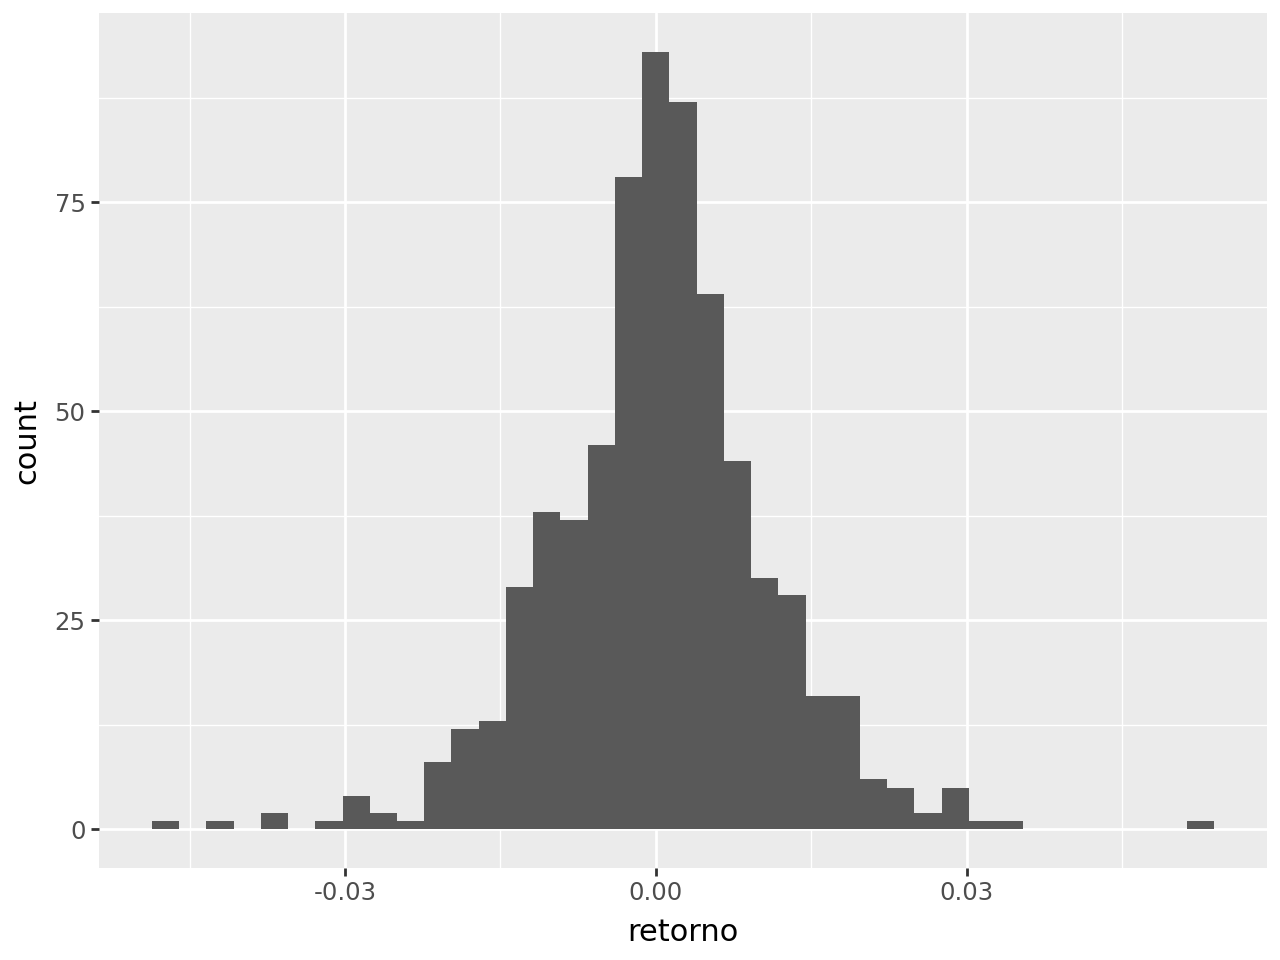

In [93]:
returns_SLSQP_2022_onwards.reset_index().rename(columns={0:'retorno'}) >> ggplot() + geom_histogram(aes(x='retorno'))

In [94]:
returns_SLSQP_2022_onwards.describe()*100, returns_SLSQP_2022_onwards.std()

(count    67200.000000
 mean         0.032248
 std          1.060088
 min         -4.697709
 25%         -0.528342
 50%          0.019767
 75%          0.603477
 max          5.292468
 dtype: float64,
 0.010600882430903992)

In [ ]:
(0.032248/0.0106)/(0.0216/0.009261) #sharpe slsqp over sharpe dji

1.3043707547169812

In [95]:
cambios_dji_hist.reset_index() >> filter(_.Date >= '2022-01-01') >> summarize(mean_return = _.Close.mean()*100, risk_return = _.Close.std())

,mean_return,risk_return
0,0.021651,0.009261


In [106]:
# prueba de que promedio diario no es la razon de crecimiento diario
prom_diario_vector=[returns_SLSQP_2022_onwards.mean()]*len(returns_SLSQP_2022_onwards)
print(prom_diario_vector)


returns_slsqp_promDiario_2022=[1+x for x in prom_diario_vector]


returns_slsqp_promDiario_2022.insert(0,1_000_000)


pd.Series(returns_slsqp_promDiario_2022).cumprod()

[0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.00032247967495483494, 0.0003224796749

0      1.000000e+06
1      1.000322e+06
2      1.000645e+06
3      1.000968e+06
4      1.001291e+06
           ...     
668    1.240335e+06
669    1.240735e+06
670    1.241135e+06
671    1.241536e+06
672    1.241936e+06
Length: 673, dtype: float64

In [96]:
returns_slsqp_2022=[1+x for x in returns_SLSQP_2022_onwards]
returns_slsqp_2022.insert(0,1_000_000)
pd.Series(returns_slsqp_2022).cumprod()


0      1.000000e+06
1      9.979332e+05
2      9.827939e+05
3      9.751628e+05
4      9.655405e+05
           ...     
668    1.166353e+06
669    1.183255e+06
670    1.183469e+06
671    1.192527e+06
672    1.195970e+06
Length: 673, dtype: float64

In [99]:
close_dji_2022=cambios_dji_hist.reset_index() >> filter(_.Date >= '2022-01-04') >> select(_.Close) >> _['Close']
returns_dji_2022=[1+x for x in close_dji_2022]
returns_dji_2022.insert(0,1_000_000)
pd.Series(returns_dji_2022).cumprod()

0      1.000000e+06
1      1.005866e+06
2      9.951360e+05
3      9.904718e+05
4      9.903404e+05
           ...     
668    1.091568e+06
669    1.109451e+06
670    1.108101e+06
671    1.113660e+06
672    1.116379e+06
Length: 673, dtype: float64

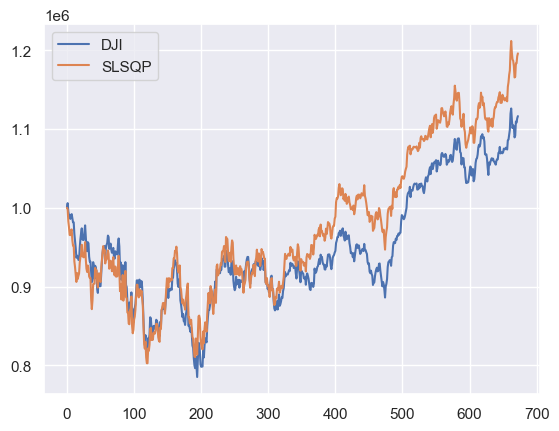

In [100]:
pd.DataFrame(np.column_stack([pd.Series(returns_dji_2022).cumprod(), pd.Series(returns_slsqp_2022).cumprod()]),columns=['DJI','SLSQP']).plot()
plt.show()